# Nearest-Neightbor Graph

## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE


In [3]:
from google.colab import userdata, drive
import os

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
base_path = "drive/MyDrive/Education/STAT 5330 Project/"
fp = "data/phase_1/encoder_transformed_data.csv"
path = os.path.join(base_path, fp)

z = pd.read_csv(path)

print(z.shape)
z.head()

(1176724, 4)


,0,1,2,3
0,3.205000,-0.065240,2.100247,-0.026560
1,1.721211,-6.710943,-0.466486,-1.532964
2,4.382347,-0.072930,3.094351,3.113639
3,2.963240,-1.450746,2.764051,-0.322974
4,3.808329,-2.826105,3.746666,0.540323


In [5]:
n = 100_000
idx = np.random.choice(z.index, n, False)

z_sample = z.copy().iloc[idx].reset_index(drop=True)
print(z_sample.shape)
z_sample

(100000, 4)


,0,1,2,3
0,2.960553,-0.916769,2.454134,1.319768
1,3.175263,-0.304434,1.246457,-0.875990
2,2.797481,-1.068465,4.120725,0.792351
3,3.640691,-1.455590,3.797172,1.531016
4,8.203306,1.218905,9.064062,5.096675
...,...,...,...,...
99995,2.670430,-1.411619,2.534934,-0.474262
99996,3.736048,-1.433812,4.260431,1.268051
99997,3.007651,-1.153144,3.012103,1.867628
99998,1.988463,-6.815593,-0.136643,-0.590378


In [6]:
fp = "data/general/track_metadata.csv"
path = os.path.join(base_path, fp)

meta = pd.read_csv(path)
meta_sample = meta.iloc[idx].reset_index(drop=True)

fp = "data/general/sampled_track_metadata.csv"
path = os.path.join(base_path, fp)

meta_sample.to_csv(path, index= False)

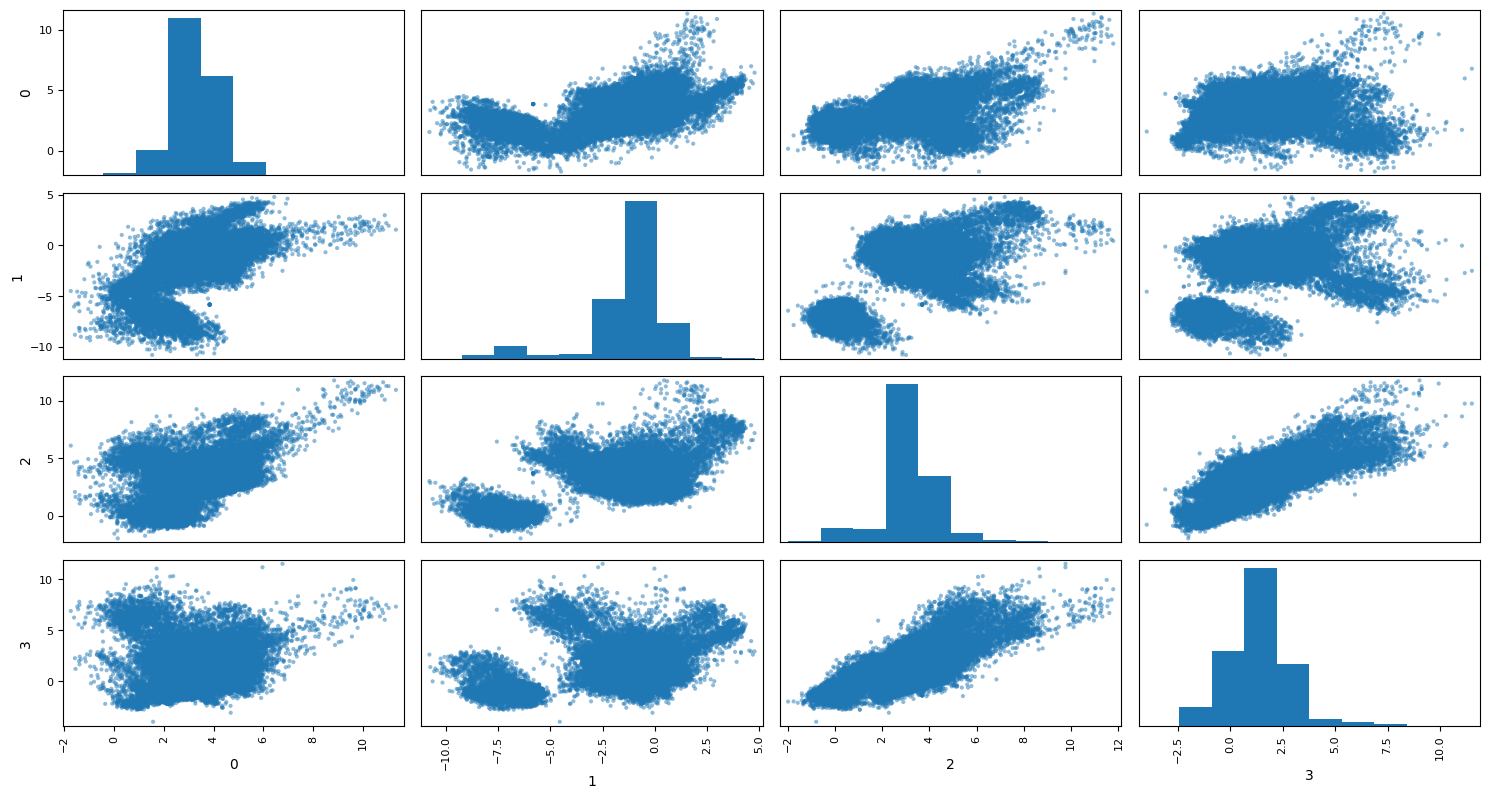

In [7]:
pd.plotting.scatter_matrix(z_sample, figsize=(15,8));
plt.tight_layout()

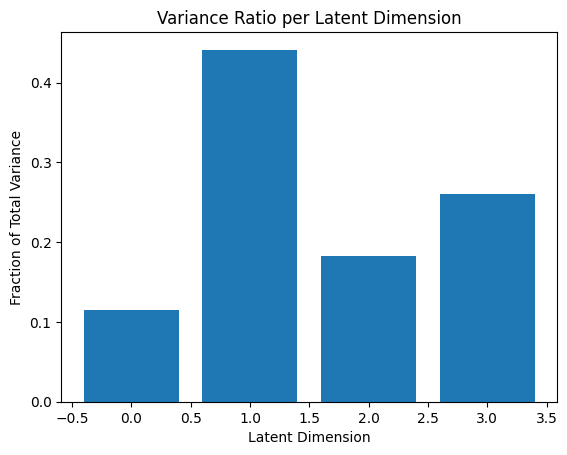

In [8]:
var = np.var(z, axis=0)
var_ratio = var / np.sum(var)

pd.DataFrame({
    "latent_dim": range(len(var)),
    "variance": var,
    "variance_ratio": var_ratio
})
plt.bar(range(len(var)), var_ratio)
plt.title("Variance Ratio per Latent Dimension")
plt.xlabel("Latent Dimension")
plt.ylabel("Fraction of Total Variance")
plt.show();

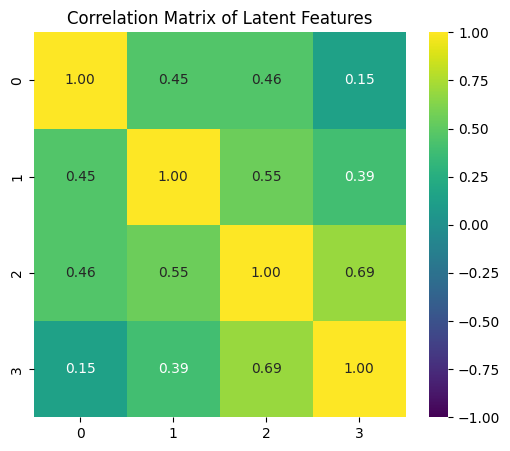

In [9]:
corr = np.corrcoef(z.T)
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Latent Features")
plt.show();

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Z_2d = TSNE(n_components=2, perplexity=50, random_state=42, n_jobs=-1).fit_transform(z_sample[:10_000])

In [ ]:
z_sample[:10_000]

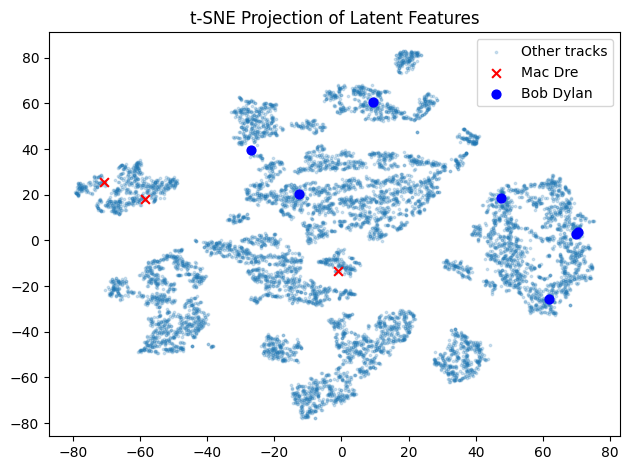

In [11]:
def get_artist_idx(artist):
  idx = meta_sample[meta_sample["main_artist"] == artist].index.to_numpy()
  return idx[idx < 10_000]

artist_1 = "Mac Dre"
artist_2 = "Bob Dylan"

idx_1 = get_artist_idx(artist_1)
idx_2 = get_artist_idx(artist_2)

plt.scatter(Z_2d[:, 0],
            Z_2d[:, 1],
            s=3,
            alpha=0.2,
            label="Other tracks"
            )

plt.scatter(
    Z_2d[idx_1, 0],
    Z_2d[idx_1, 1],
    s=40,
    marker="x",
    label=artist_1,
    color = "red"
)

plt.scatter(
    Z_2d[idx_2, 0],
    Z_2d[idx_2, 1],
    s=40,
    marker="o",
    label=artist_2,
    color = "b"
)


plt.title("t-SNE Projection of Latent Features")
plt.legend()
plt.tight_layout()
plt.show()

## Graph Building

In [12]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, diags, save_npz
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def build_knn_graph(
    Z,
    k=20
):

    Z = np.asarray(Z)
    n_samples = Z.shape[0]

    nn = NearestNeighbors(
        n_neighbors=k + 1,
        metric="euclidean",
        n_jobs=-1
    )
    nn.fit(Z)
    distances, indices = nn.kneighbors(Z)

    distances = distances[:, 1:]
    indices = indices[:, 1:]

    row_ind = np.repeat(np.arange(n_samples), k)
    col_ind = indices.ravel()

    similarity = 1 / (1 + distances)
    data = similarity.ravel().astype(np.float32)

    W = csr_matrix((data, (row_ind, col_ind)), shape=(n_samples, n_samples))
    W = 0.5 * (W + W.T)

    return W


In [13]:
k_clusters = 20

W = build_knn_graph(
    z_sample,
    k=k_clusters
)

print(W.shape)
print(W.nnz)


(100000, 100000)
2535765


In [14]:
L_sym = laplacian(W, normed=True)

vals, vecs = eigsh(L_sym, k=k_clusters, which="SM")

idx = np.argsort(vals)
vals = vals[idx]
vecs = vecs[:, idx]

vecs_for_clustering = vecs

row_norms = np.linalg.norm(vecs_for_clustering, axis=1, keepdims=True)
row_norms[row_norms == 0] = 1.0

Y = vecs_for_clustering / row_norms

In [24]:
kmeans = KMeans(n_clusters=k_clusters, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(Y[:10_000])

In [22]:
Y_2d = TSNE(n_components=2, perplexity=50, random_state=42, n_jobs=-1).fit_transform(Y[:10_000])

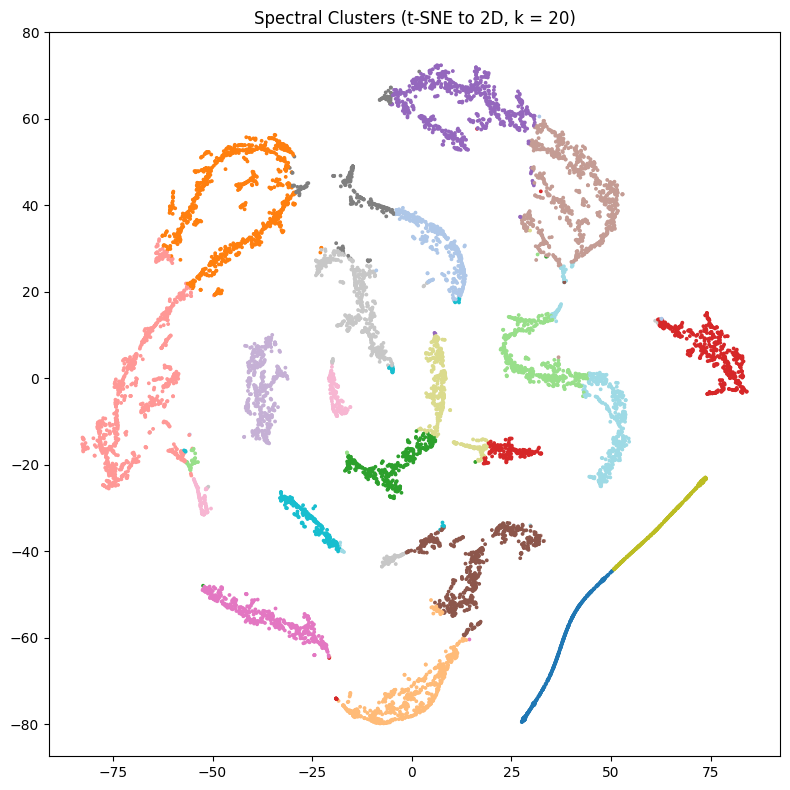

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(Y_2d[:,0], Y_2d[:,1], c=cluster_labels, s=3, cmap='tab20')
plt.title(f"Spectral Clusters (t-SNE to 2D, k = {k_clusters})")

plt.tight_layout()
plt.show()

In [28]:
fp = "data/phase_2/song_graph.npz"
path = os.path.join(base_path, fp)
save_npz(path, W)

In [29]:
fp = "data/phase_2/sampled_encoder_transformed_data.csv"
path = os.path.join(base_path, fp)
z_sample.to_csv(path, index=False)